In [15]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
# 多行输出
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 

- 数据

In [14]:
from pathlib import Path
from IPython.core.debugger import set_trace
from fastai import datasets
import pickle, gzip, math, torch, matplotlib as mpl
import matplotlib.pyplot as plt
from torch import tensor

MNIST_URL='http://deeplearning.net/data/mnist/mnist.pkl'

- 下载数据

In [6]:
path = datasets.download_data(MNIST_URL, ext='.gz')
path

PosixPath('/home/lyc/.fastai/data/mnist.pkl.gz')

- 解压与加载数据

In [17]:
with gzip.open(path, 'rb') as f:
    (x_train, y_train), (x_valid, y_valid), _ = pickle.load(f, encoding='latin-1')

- 转化为torch.tensor 数据

In [18]:
x_train,y_train,x_valid,y_valid = map(tensor, (x_train,y_train,x_valid,y_valid))
n,c = x_train.shape

- 数据集的大小

In [21]:
x_train.shape,x_valid.shape, y_train.min(), y_train.max()

(torch.Size([50000, 784]), torch.Size([10000, 784]), tensor(0), tensor(9))

- 灰度图

In [22]:
mpl.rcParams['image.cmap'] = 'gray'

In [35]:
img = x_train[180]  # 归一化数据

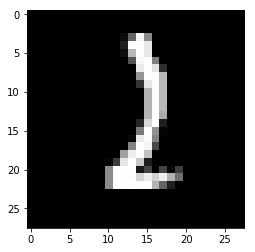

In [36]:
plt.imshow(img.view((28,28)));

In [41]:
img1 = img.view(28, 28)

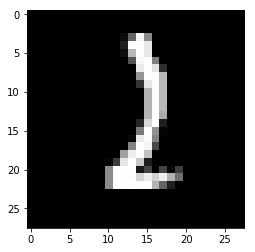

In [42]:
plt.imshow(img1)

In [44]:
img1[..., None].size()

torch.Size([28, 28, 1])

In [47]:
torch.unsqueeze(img1, 0).size()
torch.unsqueeze(img1, 1).size()

torch.Size([1, 28, 28])

torch.Size([28, 1, 28])

In [51]:
# torch.einsum??

In [53]:
ret1 = img1 * img1

In [59]:
ret2 = torch.einsum('ij, ij->ij', img1, img1)

In [60]:
torch.allclose(ret1, ret2)

True

- zscore 标准化

In [61]:
def normalize(x, m, s): return (x-m)/s

```Python
# simplified kaiming init / he init
w1 = torch.randn(m,nh)/math.sqrt(m)
b1 = torch.zeros(nh)
w2 = torch.randn(nh,1)/math.sqrt(nh)
b2 = torch.zeros(1)
```

In [64]:
from torch.nn import init

In [66]:
init.kaiming_normal_??

Signature: init.kaiming_normal_(tensor, a=0, mode='fan_in', nonlinearity='leaky_relu')
Source:   
def kaiming_normal_(tensor, a=0, mode='fan_in', nonlinearity='leaky_relu'):
    r"""Fills the input `Tensor` with values according to the method
    described in `Delving deep into rectifiers: Surpassing human-level
    performance on ImageNet classification` - He, K. et al. (2015), using a
    normal distribution. The resulting tensor will have values sampled from
    :math:`\mathcal{N}(0, \text{std})` where

    .. math::
        \text{std} = \sqrt{\frac{2}{(1 + a^2) \times \text{fan\_in}}}

    Also known as He initialization.

    Args:
        tensor: an n-dimensional `torch.Tensor`
        a: the negative slope of the rectifier used after this layer (0 for ReLU
            by default)
        mode: either ``'fan_in'`` (default) or ``'fan_out'``. Choosing ``'fan_in'``
            preserves the magnitude of the variance of the weights in the
            forward pass. Choosing ``'fan_ou

为什么一个好的初始化的很重要的
- 随机初始化会导致梯度爆炸
- 当乘上一个小数时就会梯度消失

In [89]:
x = torch.randn(512)
a = torch.randn(512,512)

In [86]:
for _ in range(100): x = a @ x

In [87]:
x.mean(), x.std()

(tensor(nan), tensor(nan))

In [91]:
x = torch.randn(512)
a = torch.randn(512,512)
for i in range(100): 
    x = a @ x
    if x.std() != x.std(): break
i

28

- 在28次就出现了均值方差的偏移

In [94]:
x = torch.randn(512)
a = torch.randn(512,512) * 0.01
for i in range(100): x = a @ x
x.mean(), x.std()

(tensor(0.), tensor(0.))

- 使用标准偏差(Xavier初始化。 使用等于1 / math.sqrt（n_in）的比例，其中n_in是我们矩阵的输入维度)
- 使用正交矩阵初始化权重（正交矩阵具有保留L2范数的特殊属性，因此在这种情况下x和Ax将具有相同的平方和）
- 在矩阵A上使用频谱归一化

In [95]:
import math

In [96]:
x = torch.randn(512)
a = torch.randn(512,512) / math.sqrt(512)
for i in range(100): x = a @ x
x.mean(),x.std()

(tensor(0.0628), tensor(1.5498))

- 损失函数

softmax:

$$\hbox{softmax(x)}_{i} = \frac{e^{x_{i}}}{\sum_{0 \leq j \leq n-1} e^{x_{j}}}$$ 

实际上，当我们计算损失时，我们对softmax取对数。

In [99]:
def log_softmax(x): return (x.exp()/(x.exp().sum(-1, keepdim=True))).log()
def log_softmax(x): return x - x.exp().sum(-1,keepdim=True).log()  # 化简

In [100]:
class Optimizer():
    def __init__(self, params, lr=0.5):
        self.params,self.lr = list(params),lr
        
    def step(self):
        with torch.no_grad():
            for p in self.params: p -= p.grad * lr

    def zero_grad(self):
        for p in self.params: p.grad.data.zero_()

In [101]:
class Dataset():
    def __init__(self, x, y): self.x,self.y = x,y
    def __len__(self): return len(self.x)
    def __getitem__(self, i): return self.x[i],self.y[i]

In [102]:
# class DataLoader():
#     def __init__(self, ds, bs): self.ds,self.bs = ds,bs
#     def __iter__(self):
#         for i in range(0, len(self.ds), self.bs): yield self.ds[i:i+self.bs]

In [103]:
class Sampler():
    def __init__(self, ds, bs, shuffle=False):
        self.n,self.bs,self.shuffle = len(ds),bs,shuffle
        
    def __iter__(self):
        self.idxs = torch.randperm(self.n) if self.shuffle else torch.arange(self.n)
        for i in range(0, self.n, self.bs): yield self.idxs[i:i+self.bs]

In [104]:
def collate(b):
    xs,ys = zip(*b)
    return torch.stack(xs),torch.stack(ys)

class DataLoader():
    def __init__(self, ds, sampler, collate_fn=collate):
        self.ds,self.sampler,self.collate_fn = ds,sampler,collate_fn
        
    def __iter__(self):
        for s in self.sampler: yield self.collate_fn([self.ds[i] for i in s])

- 数据流程：数据集-采样-collate-dataloader
- 采样器是获得索引
- 先由索引获得数据，之后由 collate_fn 对数据进行整合

**DataBunch是对dataloader的再次封装, learn 是 （model, loss_func, opt, databunch）的封装**

- fit(epochs, model, loss_func, opt, train_dl, valid_dl) ===>> fit(epochs, model, loss_func, opt, databunch) ===>> fit(1, learn)

In [106]:
class DataBunch():
    def __init__(self, train_dl, valid_dl, c=None):
        self.train_dl,self.valid_dl,self.c = train_dl,valid_dl,c
        
    @property
    def train_ds(self): return self.train_dl.dataset
        
    @property
    def valid_ds(self): return self.valid_dl.dataset

In [107]:
def get_model(data, lr=0.5, nh=50):
    m = data.train_ds.x.shape[1]
    model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,data.c))
    return model, optim.SGD(model.parameters(), lr=lr)

class Learner():
    def __init__(self, model, opt, loss_func, data):
        self.model,self.opt,self.loss_func,self.data = model,opt,loss_func,data

```Python
learn = Learner(*get_model(data), loss_func, data)
```

In [109]:
import re

_camel_re1 = re.compile('(.)([A-Z][a-z]+)')
_camel_re2 = re.compile('([a-z0-9])([A-Z])')
def camel2snake(name):
    s1 = re.sub(_camel_re1, r'\1_\2', name)
    return re.sub(_camel_re2, r'\1_\2', s1).lower()

In [113]:
camel2snake('UsefullName')

'usefull_name'

In [131]:
def listify(o):
    if o is None: return []
    if isinstance(o, list): return o
    if isinstance(o, str): return [o]
    if isinstance(o, Iterable): return list(o)
    return [o]

- 学习率衰减

In [117]:
from functools import partial

In [115]:
def annealer(f):
    def _inner(start, end): return partial(f, start, end)
    return _inner

@annealer
def sched_lin(start, end, pos): return start + pos*(end-start)
@annealer
def sched_cos(start, end, pos): return start + (1 + math.cos(math.pi*(1-pos))) * (end-start) / 2
@annealer
def sched_no(start, end, pos):  return start
@annealer
def sched_exp(start, end, pos): return start * (end/start) ** pos

In [23]:
#This monkey-patch is there to be able to plot tensors
torch.Tensor.ndim = property(lambda x: len(x.shape))

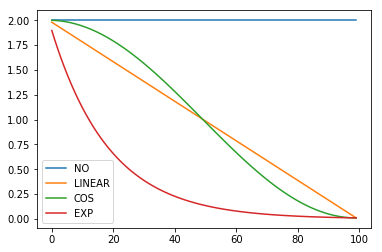

In [128]:
annealings = "NO LINEAR COS EXP".split()

a = torch.arange(0, 100)
p = torch.linspace(0.01,1,100)

fns = [sched_no, sched_lin, sched_cos, sched_exp]
for fn, t in zip(fns, annealings):
    f = fn(2, 1e-2)
    plt.plot(a, [f(o) for o in p], label=t)
plt.legend();

- 混合策略

In [129]:
def combine_scheds(pcts, scheds):
    assert sum(pcts) == 1.
    pcts = tensor([0] + listify(pcts))
    assert torch.all(pcts >= 0)
    pcts = torch.cumsum(pcts, 0)
    def _inner(pos):
        idx = (pos >= pcts).nonzero().max()
        actual_pos = (pos-pcts[idx]) / (pcts[idx+1]-pcts[idx])
        return scheds[idx](actual_pos)
    return _inner

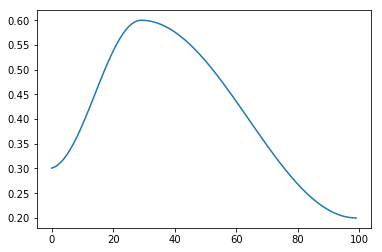

In [132]:
sched = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)]) 
plt.plot(a, [sched(o) for o in p])

In [133]:
tensor([0] + listify([0.3, 0.7]))

tensor([0.0000, 0.3000, 0.7000])

In [137]:
import ipywidgets as widgets

In [138]:
def f(o): print('hi')

In [139]:
w = widgets.Button(description='Click me')

In [141]:
w.on_click(f)

- 实现回调函数

In [1]:
from time import sleep

In [2]:
def slow_calculation(cb=None):
    res = 0
    for i in range(5):
        res += i*i
        sleep(1)
        if cb: cb(i)
    return res

In [3]:
slow_calculation()

30

In [4]:
def show_progress(epoch):
    print(f"Awesome! We've finished epoch {epoch}!")

In [5]:
slow_calculation(show_progress)

Awesome! We've finished epoch 0!
Awesome! We've finished epoch 1!
Awesome! We've finished epoch 2!
Awesome! We've finished epoch 3!
Awesome! We've finished epoch 4!


30

In [6]:
from functools import partial

- 用类实现callback

In [7]:
def slow_calculation(cb=None):
    res = 0
    for i in range(5):
        if cb: cb.before_calc(i)
        res += i*i
        sleep(1)
        if cb: cb.after_calc(i, val=res)
    return res

In [11]:
class PrintStatusCallback:
    def __init__(self): pass
    def before_calc(self, epoch, **kwargs): print(f"About to start: {epoch}")
    def after_calc (self, epoch, val, **kwargs): print(f"After {epoch}: {val}")

In [13]:
slow_calculation(PrintStatusCallback())

About to start: 0
After 0: 0
About to start: 1
After 1: 1
About to start: 2
After 2: 5
About to start: 3
After 3: 14
About to start: 4
After 4: 30


30

- plt 画 tensor

In [16]:
u = torch.randn(10)

In [18]:
v = u ** 2

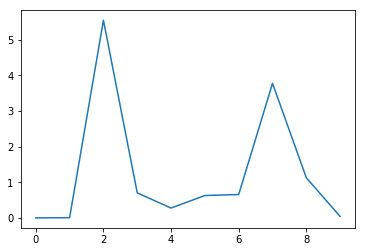

In [26]:
plt.plot(v)

In [27]:
property??

Init signature: property(self, /, *args, **kwargs)
Docstring:     
property(fget=None, fset=None, fdel=None, doc=None) -> property attribute

fget is a function to be used for getting an attribute value, and likewise
fset is a function for setting, and fdel a function for del'ing, an
attribute.  Typical use is to define a managed attribute x:

class C(object):
    def getx(self): return self._x
    def setx(self, value): self._x = value
    def delx(self): del self._x
    x = property(getx, setx, delx, "I'm the 'x' property.")

Decorators make defining new properties or modifying existing ones easy:

class C(object):
    @property
    def x(self):
        "I am the 'x' property."
        return self._x
    @x.setter
    def x(self, value):
        self._x = value
    @x.deleter
    def x(self):
        del self._x
Type:           type
Subclasses:     abstractproperty, pybind11_static_property, _DependentProperty
